## Import libraries

In [6]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

## Import Data

In [17]:
# import kagglehub
#
# # Download latest version
# path = kagglehub.dataset_download("vjchoudhary7/customer-segmentation-tutorial-in-python")
#
# print("Path to dataset files:", path)

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv"
df_full = pd.read_csv(url)

df_full.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [18]:
df = df_full[['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']].copy()
df.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


## Normalize the Features

going to write about what normalization is here

In [19]:
X = StandardScaler().fit_transform(df)

## PCA Reduced data BEFORE Clustering

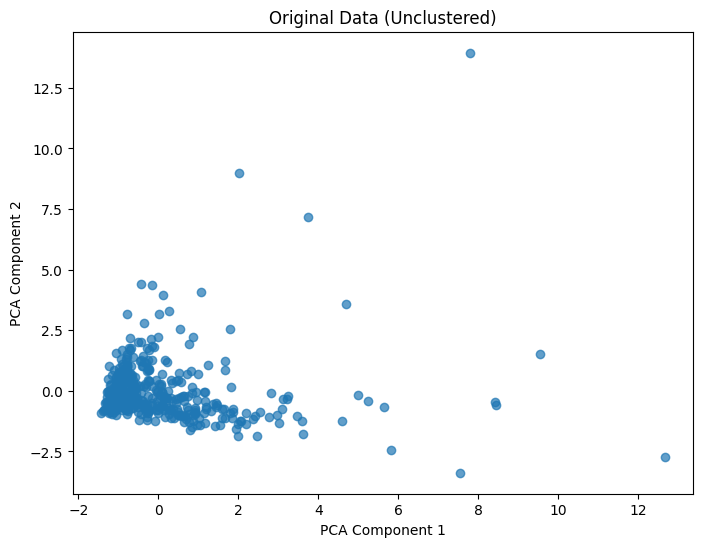

In [20]:
# Reduce to 2D for visualization
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(X_2d[:,0], X_2d[:,1], alpha=0.7)
plt.title("Original Data (Unclustered)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

## PCA Visualization segmented by Channel

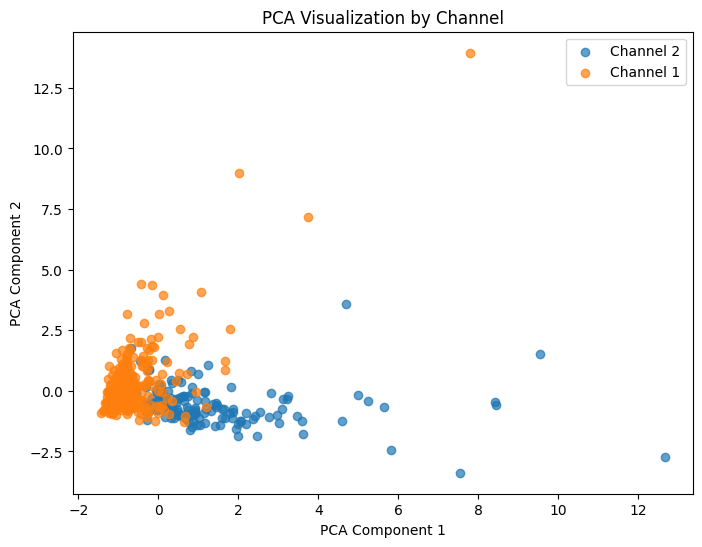

In [21]:
# PCA coords already computed: X_2d
df_full["PC1"] = X_2d[:,0]
df_full["PC2"] = X_2d[:,1]

plt.figure(figsize=(8,6))
for ch in df_full["Channel"].unique():
    subset = df_full[df_full["Channel"] == ch]
    plt.scatter(subset["PC1"], subset["PC2"], label=f"Channel {ch}", alpha=0.7)

plt.title("PCA Visualization by Channel")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()

## PCA Visualization segmented by Region

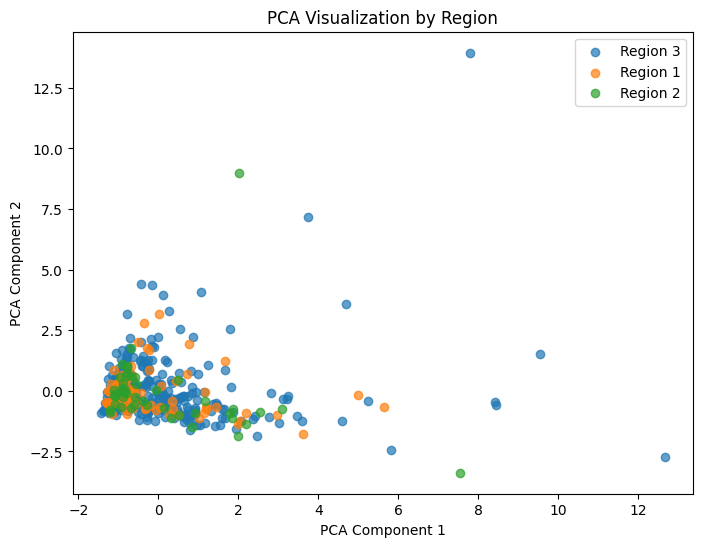

In [24]:
plt.figure(figsize=(8,6))
for reg in df_full["Region"].unique():
    subset = df_full[df_full["Region"] == reg]
    plt.scatter(subset["PC1"], subset["PC2"], label=f"Region {reg}", alpha=0.7)

plt.title("PCA Visualization by Region")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()

## Choosing Linking method

In [13]:
# Linkage matrix using Ward's method
Z = linkage(X, method='ward')

# Choose number of clusters (e.g., 3)
labels = fcluster(Z, t=3, criterion='maxclust')

## PCA Reduced data AFTER Clustering

### loop through all the linkage methods

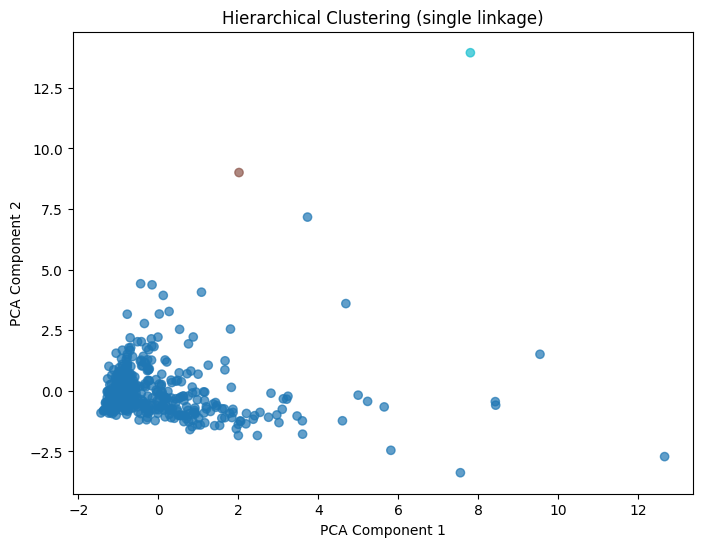

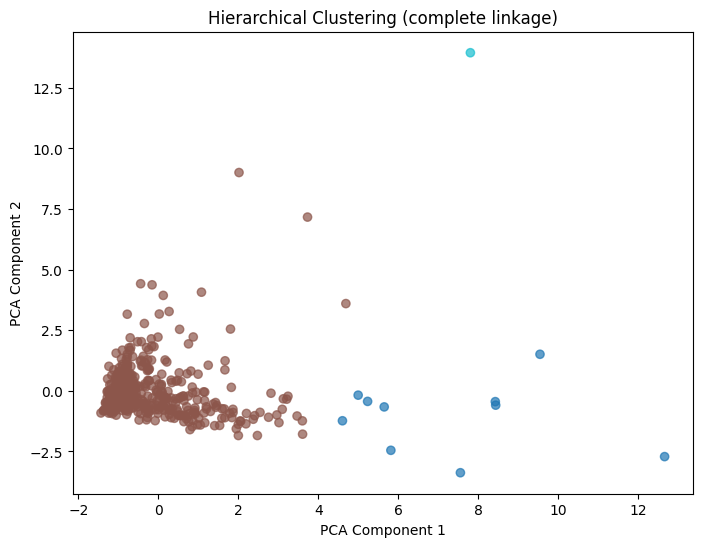

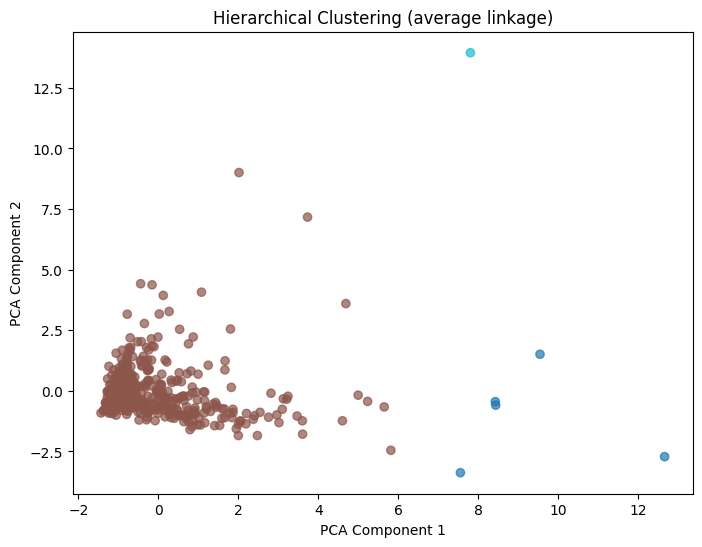

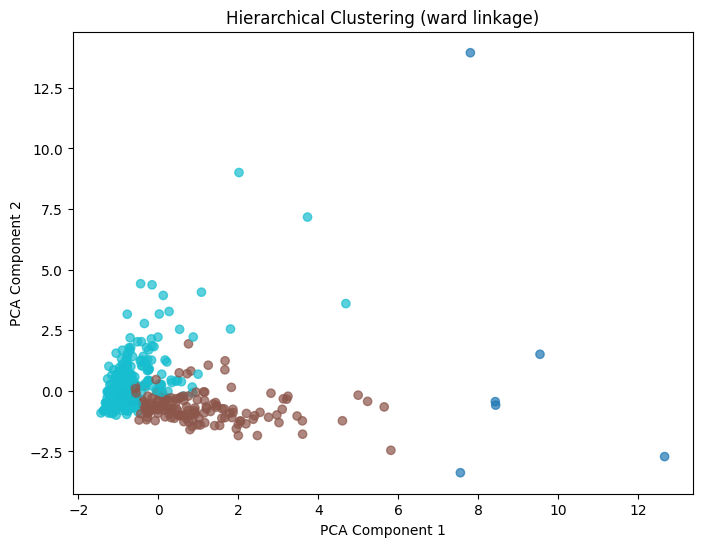

In [28]:
methods = ["single", "complete", "average", "ward"]

for m in methods:
    # compute linkage for this method
    Z = linkage(X, method=m)

    # choose k clusters (example: k=3)
    labels = fcluster(Z, t=3, criterion="maxclust")

    # plot
    plt.figure(figsize=(8,6))
    plt.scatter(X_2d[:,0], X_2d[:,1], c=labels, cmap='tab10', alpha=0.7)
    plt.title(f"Hierarchical Clustering ({m} linkage)")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.show()


## How HC does the clustering (dendrogram)

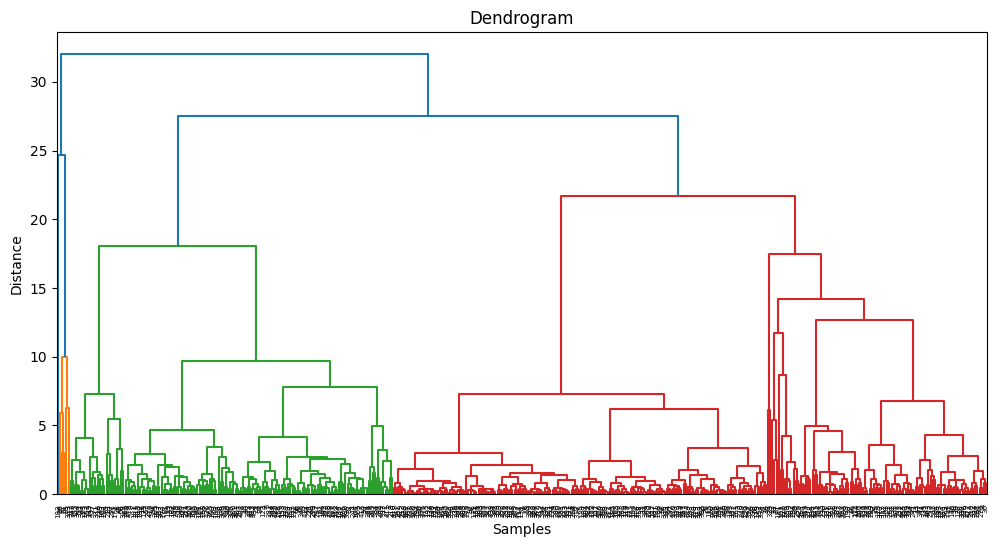

In [16]:
plt.figure(figsize=(12,6))
dendrogram(Z)
plt.title("Dendrogram")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.show()